Import frames and train, test, evaluate network on facial images

# Importing Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
PROJECT_FOLDER = '/content/drive/MyDrive/CNN_Emotion_Classification/'

In [ ]:
# %cd /content/drive/MyDrive/CNN_Emotion_Classification/

In [ ]:
# copy content in main folder
! cp -a {PROJECT_FOLDER}. ./

In [ ]:
!pip install -r Requirements/pireqs_opencv_contrib_env.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.7 MB/s eta 0:00:00


In [ ]:
# !pip install keras_applications

In [ ]:
from display import pltDisplay
from pathlib import Path
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
# from sorting import human_sort
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation, ReLU, Softmax, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
# import IPython.display as ipd


import constants as const
import csv
import cv2
import json
import logging
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
import subprocess
import tensorflow.keras.backend as K
import time
import utils

from keras_vggface.vggface import VGGFace
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_imagenet
from keras_vggface.utils import preprocess_input as preprocess_vggface

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        print("Name:", gpu.name, "  Type:", gpu.device_type)
        print(tf.config.experimental.get_device_details(gpu))
        print(tf.config.experimental.get_memory_info('GPU:0'))
        # tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Name: /physical_device:GPU:0   Type: GPU
{'compute_capability': (7, 5), 'device_name': 'Tesla T4'}
{'current': 0, 'peak': 0}
1 Physical GPUs, 1 Logical GPUs


In [ ]:
# unzip archive in folder
!7z x Generated/Frames_300.zip -oGenerated/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 4154172627 bytes (3962 MiB)

Extracting archive: Generated/Frames_300.zip
  2% 4096 Open              --
Path = Generated/Frames_300.zip
Type = zip
Physical Size = 4154172627
64-bit = +

  0%      0% 276 - Frames/angry/01/01-01-05-01-02-01-01-042-01.jpg                                                            0% 577 - Frames/angry/01/01-01-05-02-01-02-01-006-00.jpg                                                            0% 798 - Frames/angry/01/01-

In [ ]:
utils.modules_info()


    OpenCV:
        Version: 4.8.0
    Tensorflow:
        Version: 2.15.0
    


In [ ]:
log_file = Path(const.logs_path, 'FACER.log')
logging.basicConfig(
    format='%(asctime)s %(message)s',
    filemode='a',
    filename=log_file,
    encoding='utf-8',
    level=logging.INFO,
    force=True
)

# Importing Dataset

In [ ]:
data_df = pd.read_csv(Path(const.csv_path, 'dataset.csv'))

# Frame

## Preparing Data

### Dataset Creation for ML

In [ ]:
IMG_WIDTH = IMG_HEIGHT = 224
IMG_CHANNELS = 3
SEED = 42
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2
EMOTIONS_LABELS = const.EMOTIONS_LABELS  # RAVDESS emotion labels

In [ ]:
TOTAL_ELEMENTS = const.DATASET_TOTAL_ELEMENTS

In [ ]:
label_names = const.EMOTIONS_LABELS_SORTED.copy()

label_names_gender = []
for em in label_names:
    label_names_gender.append(em + '_female')
    label_names_gender.append(em + '_male')

#### Dataset Creation - NEW

In [ ]:
actors_labels = [f'{i:02d}' for i in range(1, 25)]
dist_idxs = {
    '1': [slice(0, 16), slice(16, 20), slice(20, 24)],
    '2': [slice(8, 24), slice(4, 8), slice(0, 4)],
    '3': [slice(4, 20), slice(20, 24), slice(0, 4)]
}

In [ ]:
# Split actors in train, validation, test
dist_n = 1
train_idxs, val_idxs, test_idxs = [actors_labels[i] for i in dist_idxs[str(dist_n)]]

print(train_idxs, val_idxs, test_idxs)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16'] ['17', '18', '19', '20'] ['21', '22', '23', '24']


In [ ]:
def preprocess_image(image, preprocess_type=None):
    if (preprocess_type == 'Imagenet'):
        image = preprocess_imagenet(image)
    elif (preprocess_type == 'VGGFace'):
        image = preprocess_vggface(image, version=1)
    else:
        image = image / 255

    return image

In [ ]:
def prep_external_image(filename, preprocess_type=None):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=IMG_CHANNELS, fancy_upscaling=False)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return image
    # return preprocess_image(image, preprocess_type)

In [ ]:
def make_dataset(path, actors_idx, talk_frame=False, acted_frame=False,
                 undersampling=False, preprocess_vgg=True, shuffle=False,
                 gender_classes=False, sampling=1):
    # gender classes -> create a men/woman category for each emotion
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=IMG_CHANNELS)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        if (preprocess_vgg == 'Imagenet'):
            image = preprocess_imagenet(image)
        elif (preprocess_vgg == 'VGGFace'):
            # function does not accept tensor
            # so convert to np and then to tensor
            # image = np.array(image)
            image = preprocess_vggface(image, version=2)
            # image = tf.convert_to_tensor(image)
        else:
            image = image / 255

        return image

    # label_names = label_names if gender_classes else label_names_gender

    filenames = []
    talk_regex = '*-01.jpg' if talk_frame else '*.jpg'
    acted_regex = '02' if acted_frame else '*'
    gen_regex = f'*-*-*-{acted_regex}-*-*-*-{talk_regex}'

    file_dict = dict()
    file_dict_gender = dict()

    for label in sorted(label_names):
        file_dict[label] = []

    for label in sorted(label_names_gender):
        file_dict_gender[label] = []


    for label in label_names:
        for actor in actors_idx:
            for file in Path(path, label, actor).glob(f'{gen_regex}'):
                gender = utils.get_gender(str(file))[1]
                lab = label + f'_{gender}'
                file_dict_gender[lab].append(str(file))
                file_dict[label].append(str(file))

    if shuffle:
        for label, item in file_dict_gender.items():
            logging.info(f'Label: {label}')
            logging.info(f'Array len: {len(item)}')
            random.Random(SEED).shuffle(item)


    # NO GENDER


    arr_len = [len(arr) for arr in file_dict.values()]

    if undersampling:
        filenames = [arr[:min(arr_len)] for arr in file_dict.values()]
    else:
        filenames = [arr for arr in file_dict.values()]

    filenames = sum(filenames, [])

    if shuffle:
        random.Random(SEED).shuffle(filenames)

    labels = []

    if (gender_classes):

        for elem in filenames:
            cl = utils.get_class_string(str(elem))
            gender = utils.get_gender(str(elem))[1]
            lab = cl + f'_{gender}'
            labels.append(label_names_gender.index(lab))
    else:
        labels = [
            label_names.index(EMOTIONS_LABELS[int(utils.get_class(elem)) - 1])
            for elem in filenames
        ]

    if (sampling < 1):
        filenames, _, labels, _ = train_test_split(
            filenames, labels, train_size=sampling, random_state=SEED
        )

    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)

    images_ds = filenames_ds.map(
        parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds = tf.data.Dataset.zip((images_ds, labels_ds))

    return [ds, filenames]

In [ ]:
sampling_rate = 1
gender_classes = False
talk_frame = True
acted_frame = False
preprocess_vgg = 'VGGFace'  # False, Imagenet or VGGFace

if (acted_frame):
    print('L\'emozione neutral verrà rimossa')
    if 'neutral' in label_names:
        label_names.remove('neutral')
    if 'neutral_female' in label_names_gender:
        label_names_gender.remove('neutral_female')
    if 'neutral_male' in label_names_gender:
        label_names_gender.remove('neutral_male')

NUM_CLASSES = len(label_names_gender) if gender_classes else len(label_names)

train_ds, train_files = make_dataset(
    const.frames_path, train_idxs, talk_frame=talk_frame, acted_frame=acted_frame,
    preprocess_vgg=preprocess_vgg, shuffle=True, gender_classes=gender_classes,
    sampling=sampling_rate
)

val_ds, val_files = make_dataset(
    const.frames_path, val_idxs, talk_frame=talk_frame, acted_frame=acted_frame,
    preprocess_vgg=preprocess_vgg, gender_classes=gender_classes,
    sampling=sampling_rate
)

test_ds, test_files = make_dataset(
    const.frames_path, test_idxs, talk_frame=talk_frame, acted_frame=acted_frame,
    preprocess_vgg=preprocess_vgg, gender_classes=gender_classes,
    sampling=sampling_rate
)

labels = label_names if not gender_classes else label_names_gender

In [ ]:
# train_ds = train_ds[:31882]
# train_files = train_files[:31882]

# val_ds = val_ds[:8426]
# val_files = val_files[:8426]

# test_ds = test_ds[:8301]
# test_files = test_files[:8301]

In [ ]:
assert len(train_ds) == len(train_files), len(train_files)
assert len(val_ds) == len(val_files), len(val_files)
assert len(test_ds) == len(test_files), len(test_files)

In [ ]:
train_ds_elements = len(train_ds)
test_ds_elements = len(test_ds)
val_ds_elements = len(val_ds)

In [ ]:
print(f'train_ds samples: {train_ds_elements}')
print(f'test_ds samples: {test_ds_elements}')
print(f'val_ds samples: {val_ds_elements}')

train_ds samples: 67906
test_ds samples: 17994
val_ds samples: 17642


## Build and train the model

Add operations to reduce read latency while training the model:

`ds.batch` Combines consecutive elements of the dataset into batches. The components of the resulting element will have an additional outer dimension, which will be *batch_size*

`ds.cache` Caches the elements in this dataset.

`ds.prefetch` Allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

In [ ]:
def configure_for_performance(ds, batch_size=BATCH_SIZE):
    ds = ds.batch(batch_size)
    # ds = ds.cache()
    # ds = ds.shuffle(buffer_size=1000)
    # ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [ ]:
for example_images, example_labels in train_ds.take(1):
    print(example_images.shape)
    print(example_labels.shape)

(128, 224, 224, 3)
(128,)


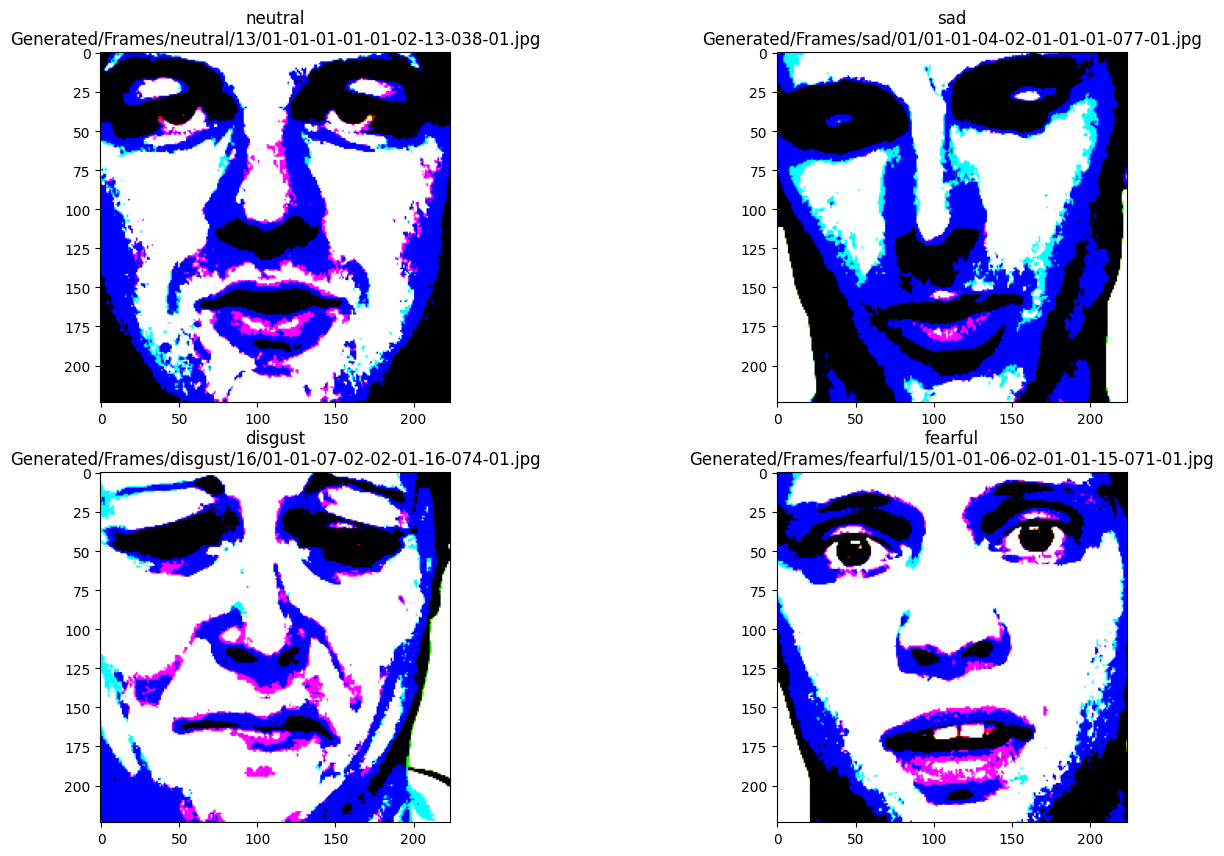

In [ ]:
plt.figure(figsize=(16, 10))
rows = 2
cols = 2
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    image = example_images[i]
    plt.imshow(image)  # 3 channels
    # plt.imshow(image * 255, cmap='gray', vmin=0, vmax=255)  # 1 channel
    plt.title(f'{label_names[example_labels[i]]}\n{train_files[i]}')

---

In [ ]:
def create_Bilotti_CNN(name='Bilotti_CNN'):

    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    conv2 = Conv2D(32, kernel_size=(3, 3), activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
    conv4 = Conv2D(64, kernel_size=(3, 3), activation='relu')(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv4 = Conv2D(18, kernel_size=(3, 3), activation='relu')(pool2)
    conv5 = Conv2D(18, kernel_size=(3, 3), activation='relu')(conv4)
    conv6 = Conv2D(18, kernel_size=(3, 3), activation='relu')(conv5)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)

    conv7 = Conv2D(56, kernel_size=(3, 3), activation='relu')(pool3)
    conv8 = Conv2D(56, kernel_size=(3, 3), activation='relu')(conv7)
    conv9 = Conv2D(56, kernel_size=(3, 3), activation='relu')(conv8)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv9)

    conv10 = Conv2D(51, kernel_size=(3, 3), activation='relu')(pool4)
    conv11 = Conv2D(51, kernel_size=(3, 3), activation='relu')(conv10)
    conv12 = Conv2D(51, kernel_size=(3, 3), activation='relu')(conv11)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv12)

    flatten = Flatten()(pool5)

    dense1 = Dense(2048, activation='relu')(flatten)
    drop1 = Dropout(0.25)(dense1)

    dense2 = Dense(1024, activation='relu')(drop1)
    drop2 = Dropout(0.4)(dense2)

    output = Dense(NUM_CLASSES, activation='softmax')(drop2)

    model = Model(inputs, output)

    model._name = name

    return model

In [ ]:
def create_VGG16_Imagenet(name='VGG16_Imagenet'):

    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
    )
    base_model.trainable = False  # Not trainable weights

    flatten_layer = Flatten()
    dense_layer_1 = Dense(2048, activation='relu')
    drop_1 = Dropout(0.4)
    dense_layer_2 = Dense(1024, activation='relu')
    drop_2 = Dropout(0.4)
    dense_layer_3 = Dense(512, activation='relu')
    drop_3 = Dropout(0.4)
    prediction_layer = Dense(NUM_CLASSES, activation='softmax')

    model = Sequential([
        base_model,
        flatten_layer,
        dense_layer_1,
        drop_1,
        dense_layer_2,
        drop_2,
        dense_layer_3,
        drop_3,
        prediction_layer
    ])

    model._name = name

    return model

In [ ]:
def create_EfficientNetB0_Imagenet(name='EfficientNetB0_Imagenet'):

    nb_class = NUM_CLASSES

    inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    model = EfficientNetB0(
        include_top=False, input_tensor=inputs, weights="imagenet"
    )

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = Dense(nb_class, activation="softmax", name="pred")(x)

    model._name = name
    # Compile
    model = Model(inputs, outputs, name="EfficientNet")

    return model

In [ ]:
def create_VGG16_VGGFACE(name='VGG16_VGGFACE'):
    nb_class = NUM_CLASSES

    vgg_model = VGGFace(
        include_top=False, weights='vggface', input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
    )
    last_layer = vgg_model.get_layer('pool5').output
    x = Flatten(name='flatten')(last_layer)

    x = Dense(512, activation='relu', name='fc6')(x)
    x = Dropout(0.35)(x)
    x = Dense(256, activation='relu', name='fc7')(x)
    x = Dropout(0.35)(x)
    x = Dense(128, activation='relu', name='fc8')(x)
    x = Dropout(0.35)(x)

    out = Dense(nb_class, activation='softmax', name='fc9')(x)

    custom_vgg_model = Model(vgg_model.input, out)
    custom_vgg_model._name = name

    return custom_vgg_model

In [ ]:
tf.keras.backend.clear_session()  # clear all precedent models and sessions

In [ ]:
check_path = 'checkpoint.weights.h5'
checkpointer = ModelCheckpoint(
    check_path, monitor='val_accuracy', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch'
)

In [ ]:
# model = create_cnn_model()
# model = medium_model()
# model = create_VGG16_Imagenet()
# model = create_VGG16_VGGFACE()
model = create_EfficientNetB0_Imagenet()
# model = create_grigorasi_model()
# model = create_Bilotti_CNN()
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][

In [ ]:
nb_class = NUM_CLASSES

vgg_model = VGGFace(
    include_top=False, weights='vggface', input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
)
vgg_model.trainable = False # freeze layer
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)

# x = Dense(512, activation='relu', name='fc6')(x)
# x = Dropout(0.35)(x)
x = Dense(256, activation='relu', name='fc7')(x)
# x = Dropout(0.35)(x)
x = Dense(128, activation='relu', name='fc8')(x)
x = Dropout(0.35)(x)

out = Dense(nb_class, activation='softmax', name='fc9')(x)

model = Model(vgg_model.input, out)
model._name = 'VGG16_VGGFACE'

58916864/58909280 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "VGG16_VGGFACE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [ ]:
# Define training callbacks

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    verbose=1,
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                              patience=3, min_lr=0)

In [ ]:
METRICS = ['accuracy']

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-4
    ),
    # optimizer=tf.keras.optimizers.SGD(),  # for VGG16_VGGFACE
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=METRICS,
)

## Train Model

In [ ]:
EPOCHS = 100
time_callback = TimeHistory()
history = model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[time_callback, early_stopping_callback, reduce_lr]
)

Epoch 1/100
531/531 [==============================] - 425s 755ms/step - loss: 0.8826 - accuracy: 0.8056 - val_loss: 3.5616 - val_accuracy: 0.4331 - lr: 1.0000e-04
Epoch 2/100
531/531 [==============================] - 373s 701ms/step - loss: 0.1894 - accuracy: 0.9358 - val_loss: 5.2741 - val_accuracy: 0.3834 - lr: 1.0000e-04
Epoch 3/100
531/531 [==============================] - 379s 713ms/step - loss: 0.1269 - accuracy: 0.9570 - val_loss: 5.3570 - val_accuracy: 0.3961 - lr: 1.0000e-04
Epoch 4/100
531/531 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.9679
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
531/531 [==============================] - 367s 690ms/step - loss: 0.0952 - accuracy: 0.9679 - val_loss: 5.4081 - val_accuracy: 0.4357 - lr: 1.0000e-04
Epoch 5/100
531/531 [==============================] - 358s 673ms/step - loss: 0.0309 - accuracy: 0.9894 - val_loss: 6.0906 - val_accuracy: 0.4264 - lr: 2.0000e-05
Epoch 6/100
531/53

In [ ]:
# FINE TUNING
# unfreeze base model
vgg_model.trainable = True
model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-5
    ),
    # optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=METRICS,
)
EPOCHS = 2
time_callback = TimeHistory()
history = model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[time_callback, early_stopping_callback, reduce_lr]
)

In [ ]:
EPOCHS = len(time_callback.times)

In [ ]:
# Create model path
model_path = Path(const.models_path, 'Frame', model._name)
run_folders = list(Path(const.models_path, 'Frame', model._name).glob('Run_*'))

if not run_folders:
    model_path = Path(model_path, 'Run_1')
else:
    last_run = run_folders.pop()
    last_run_idx = Path(last_run).name.split('_')[-1]
    model_path = Path(model_path, f'Run_{int(last_run_idx) + 1}')

model_path.mkdir(parents=True, exist_ok=False)

In [ ]:
# Save info on the indexes used for train, val and test
ds_info_path = Path(model_path, f'{model._name}_dataset.txt')
with open(ds_info_path, 'w+', newline='') as res_file:
    res_file.write(f'Train indexes: {train_idxs}\n')
    res_file.write(f'Train files: {train_ds_elements}\n')
    res_file.write(f'Val indexes: {val_idxs}\n')
    res_file.write(f'Val files: {val_ds_elements}\n')
    res_file.write(f'Test indexes: {test_idxs}\n')
    res_file.write(f'Test files: {test_ds_elements}\n')

In [ ]:
metrics = history.history

In [ ]:
mod_loss = metrics['loss']
mod_val_loss = metrics['val_loss']
mod_accuracy = metrics['accuracy']
mod_val_accuracy = metrics['val_accuracy']
# mod_f1 = metrics['fBeta_score']
# mod_val_f1 = metrics['val_fBeta_score']

mod_mean_loss = np.mean(mod_loss)
mod_mean_val_loss = np.mean(mod_val_loss)
mod_mean_accuracy = np.mean(mod_accuracy)
mod_mean_val_accuracy = np.mean(mod_val_accuracy)
# mod_mean_f1 = np.mean(mod_f1)
# mod_mean_val_f1 = np.mean(mod_val_f1)

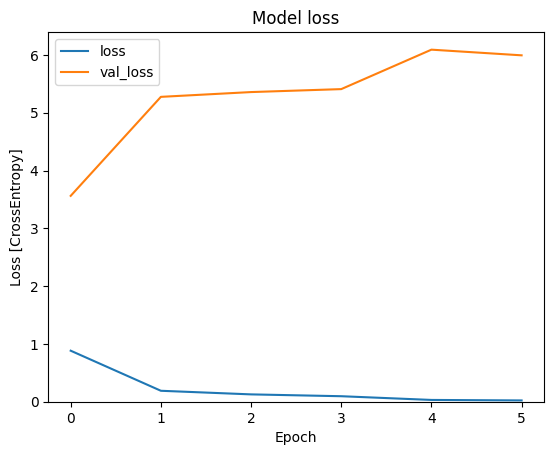

In [ ]:
# Save Loss
plt.title('Model loss')
plt.plot(history.epoch, mod_loss, mod_val_loss)
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.savefig(Path(model_path, 'loss.png'))

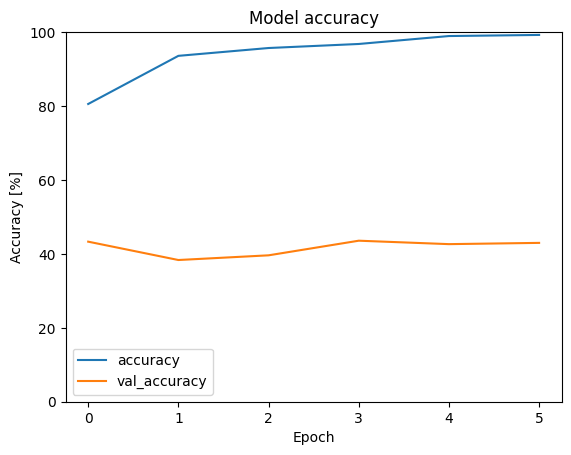

In [ ]:
# Save Accuracy
plt.title('Model accuracy')
plt.plot(
    history.epoch,
    100 * np.array(mod_accuracy),
    100 * np.array(mod_val_accuracy)
)
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.savefig(Path(model_path, 'accuracy.png'))


## Evaluate Model

In [ ]:
model_eval = model.evaluate(test_ds, return_dict=True)

141/141 [==============================] - 90s 638ms/step - loss: 3.0594 - accuracy: 0.4243


In [ ]:
# Save model
model.save(Path(model_path, f'{model._name}.keras'), overwrite=False)
# Save history
np.save(Path(model_path, f'{model._name}_history.npy'), history)
# Save model image
model_img = tf.keras.utils.plot_model(
    model, Path(model_path, f'{model._name}.png'), show_shapes=True,
    show_layer_names=True, show_layer_activations=True
)

In [ ]:
model_eval

{'loss': 3.0594334602355957, 'accuracy': 0.42430809140205383}

In [ ]:
test_loss = model_eval['loss']
test_accuracy = model_eval['accuracy']
# test_f1 = model_eval['fBeta_score']
mean_epoch_time = np.mean(time_callback.times)

In [ ]:
# Salvataggio informazioni modello
model_save_path = Path(model_path, f'{model._name}_result.txt')
with open(model_save_path, 'w+', newline='') as res_file:
    res_file.write(f'BATCH: {BATCH_SIZE}\n')
    res_file.write(f'Train loss: {str(mod_loss)}\n')
    res_file.write(f'val_loss: {str(mod_val_loss)}\n')
    res_file.write(f'Train accuracy: {str(mod_accuracy)}\n')
    res_file.write(f'Train val_accuracy: {str(mod_val_accuracy)}\n')
    # res_file.write(f'Train f1_score: {str(mod_f1)}\n')
    # res_file.write(f'Train val_f1_score: {str(mod_val_f1)}\n')
    res_file.write(f'Test loss: {str(test_loss)}\n')
    res_file.write(f'Test accuracy: {str(test_accuracy)}\n')
    # res_file.write(f'Test f1_score: {str(test_f1)}\n')
    res_file.write(f'Mean epoch time: {str(mean_epoch_time)}')

In [ ]:
# Salvataggio informazioni generali modelli
with open(Path(const.models_path, 'Frame', 'models.csv'), 'a+') as csvfile:
    filewriter = csv.writer(
        csvfile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL
    )

    # filewriter.writerow(
    #     ["Model Name", "Epochs", "% Validation", "% Test set",
    #      "Train loss", "Train accuracy", "Val loss", "Val accuracy",
    #      "Test loss", "Test accuracy", "Mean epoch time", "Note"]
    # )
    test_ds_perc = utils.trunc((test_ds_elements * 100) / TOTAL_ELEMENTS, 2)
    val_ds_perc = utils.trunc((val_ds_elements * 100) / TOTAL_ELEMENTS, 2)
    full_path = str(Path(model._name, model_path.name))
    filewriter.writerow(
        [full_path, EPOCHS, val_ds_perc, test_ds_perc,
         mod_loss, mod_accuracy, mod_val_loss, mod_val_accuracy,
         test_loss, test_accuracy, mean_epoch_time, '']
    )

In [ ]:
for test_images, test_labels in test_ds.take(1):
    print(test_images.shape)
    print(test_labels.shape)

(128, 224, 224, 3)
(128,)


Generated/Frames/angry/21/01-01-05-02-01-01-21-074-01.jpg


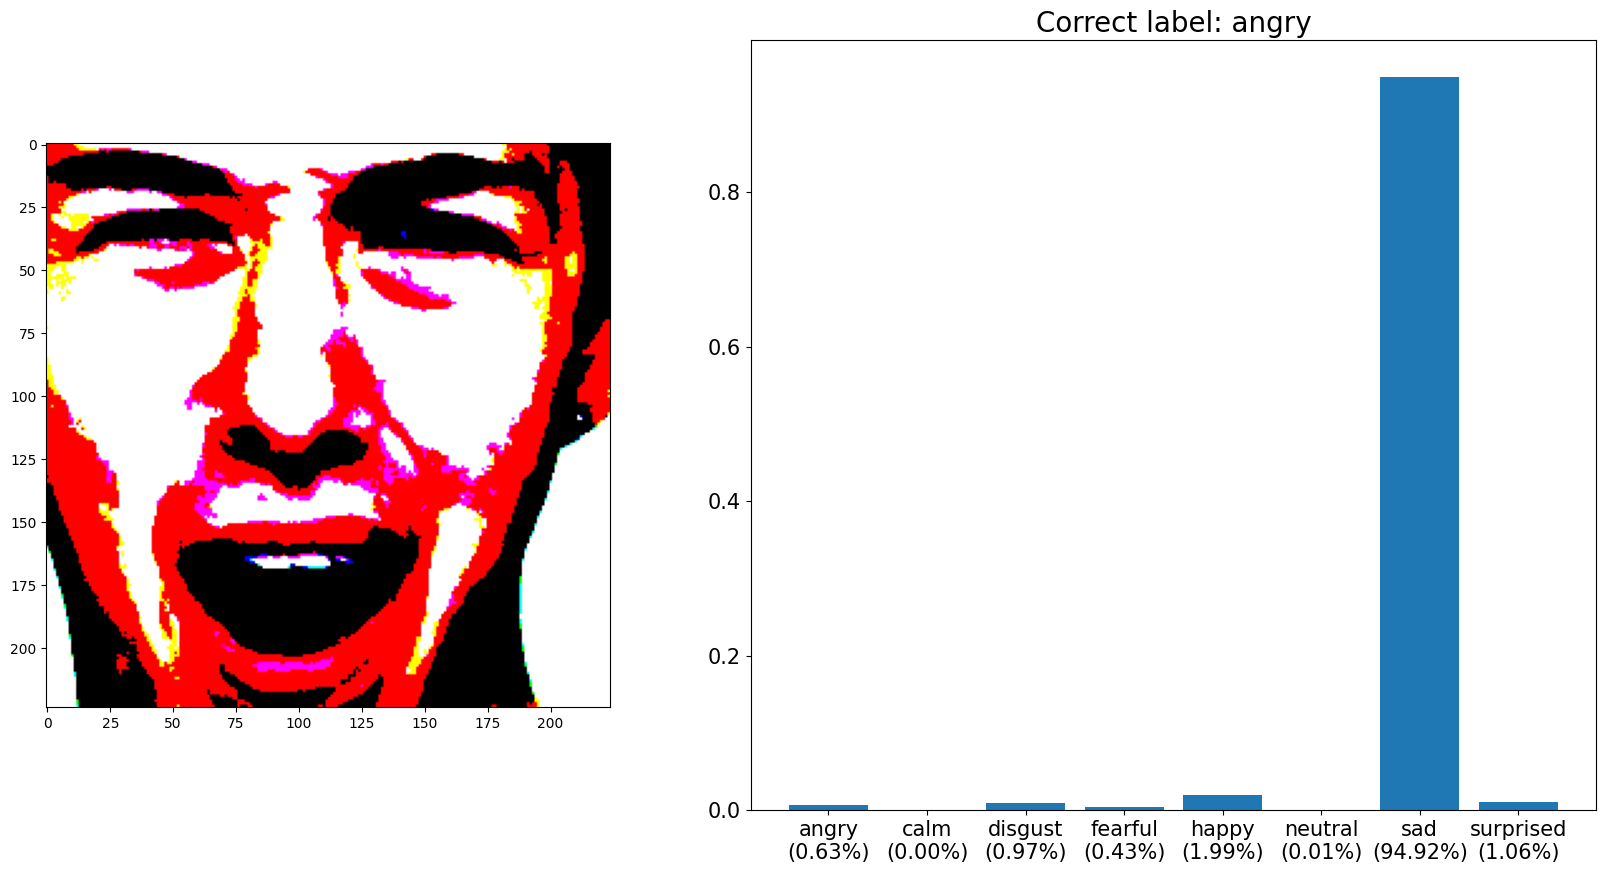

In [ ]:
gen = np.random.default_rng(seed=None)
idx = gen.integers(0, len(test_images))
print(test_files[idx])

image = test_images[idx]
label = test_labels[idx]

net_input = utils.extend_tensor(image, 0)
prediction = model(net_input)
prediction = prediction[0].numpy()

valued_arr = []

for idx, name in enumerate(label_names):
    valued_arr.append(f'{name}\n({prediction[idx]:.2%})')

fig, ax = plt.subplots(
    nrows=1, ncols=2, width_ratios=[0.4, 0.6], figsize=(20, 10)
)

pltDisplay(image * 255, ax=ax[0])  # 1 channel
# pltDisplay(image, ax=ax[0])

ax[1].bar(valued_arr, prediction)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Correct label: {label_names[label]}', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.show()

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [ ]:
y_pred = model.predict(test_ds)

141/141 [==============================] - 95s 673ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1, output_type=tf.int32)

In [ ]:
y_true = tf.concat(list(test_ds.map(lambda _, lab: lab)), axis=0)

In [ ]:
label_names

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [ ]:
report = classification_report(
    y_true, y_pred, target_names=label_names,
    output_dict=True, zero_division='warn'
)

In [ ]:
rep_to_csv = pd.DataFrame(data=report).transpose()

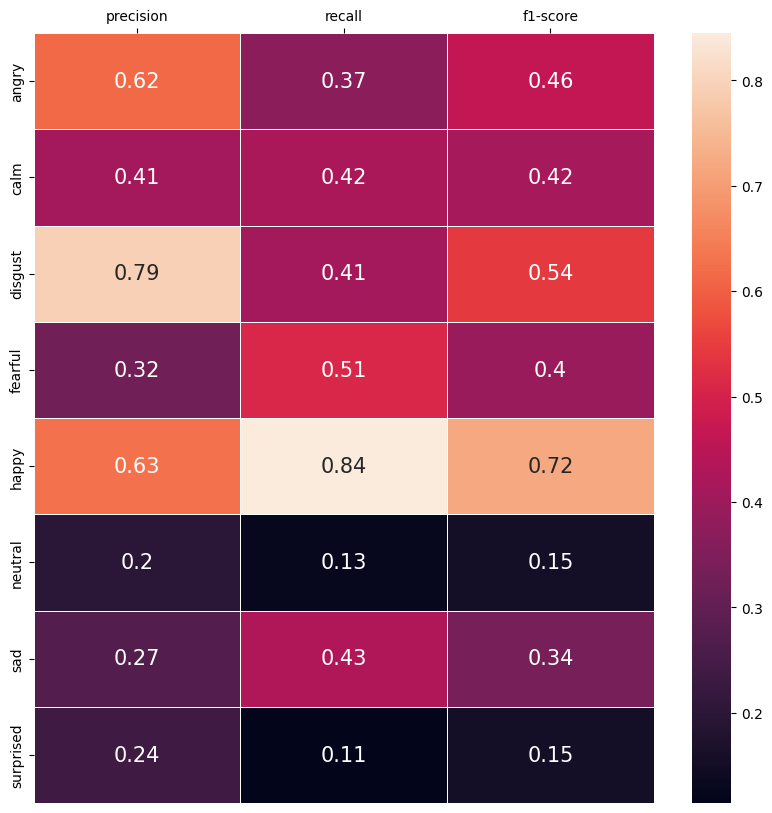

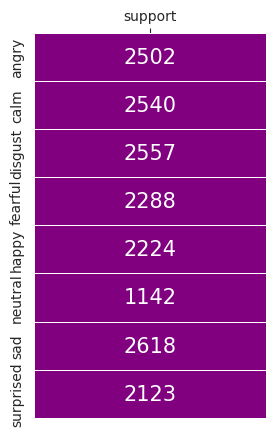

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.xaxis.tick_top()
sns.heatmap(rep_to_csv.iloc[:NUM_CLASSES, :3],
            cbar=True,
            square=False,
            annot=True,
            annot_kws={'size': 15},
            fmt='.2g',
            linewidths=0.5)
plt.savefig(Path(model_path, f'{model._name}_f1_score.png'))
plt.show()


with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(3, 5))
    ax.xaxis.tick_top()
    sns.heatmap(rep_to_csv.iloc[:NUM_CLASSES, 3:],
                cbar=False,
                square=False,
                annot=True,
                annot_kws={'size': 15},
                fmt='.4g',
                cmap=ListedColormap([('purple')]),
                linewidths=0.5)
    plt.savefig(Path(model_path, f'{model._name}_support.png'))
    plt.show()

In [ ]:
report_save_path = Path(model_path, f'{model._name}_report.csv')
rep_to_csv.to_csv(report_save_path)

In [ ]:
np.mean([report[c]['f1-score'] for c in list(report)[:NUM_CLASSES]])

0.39801310414160085

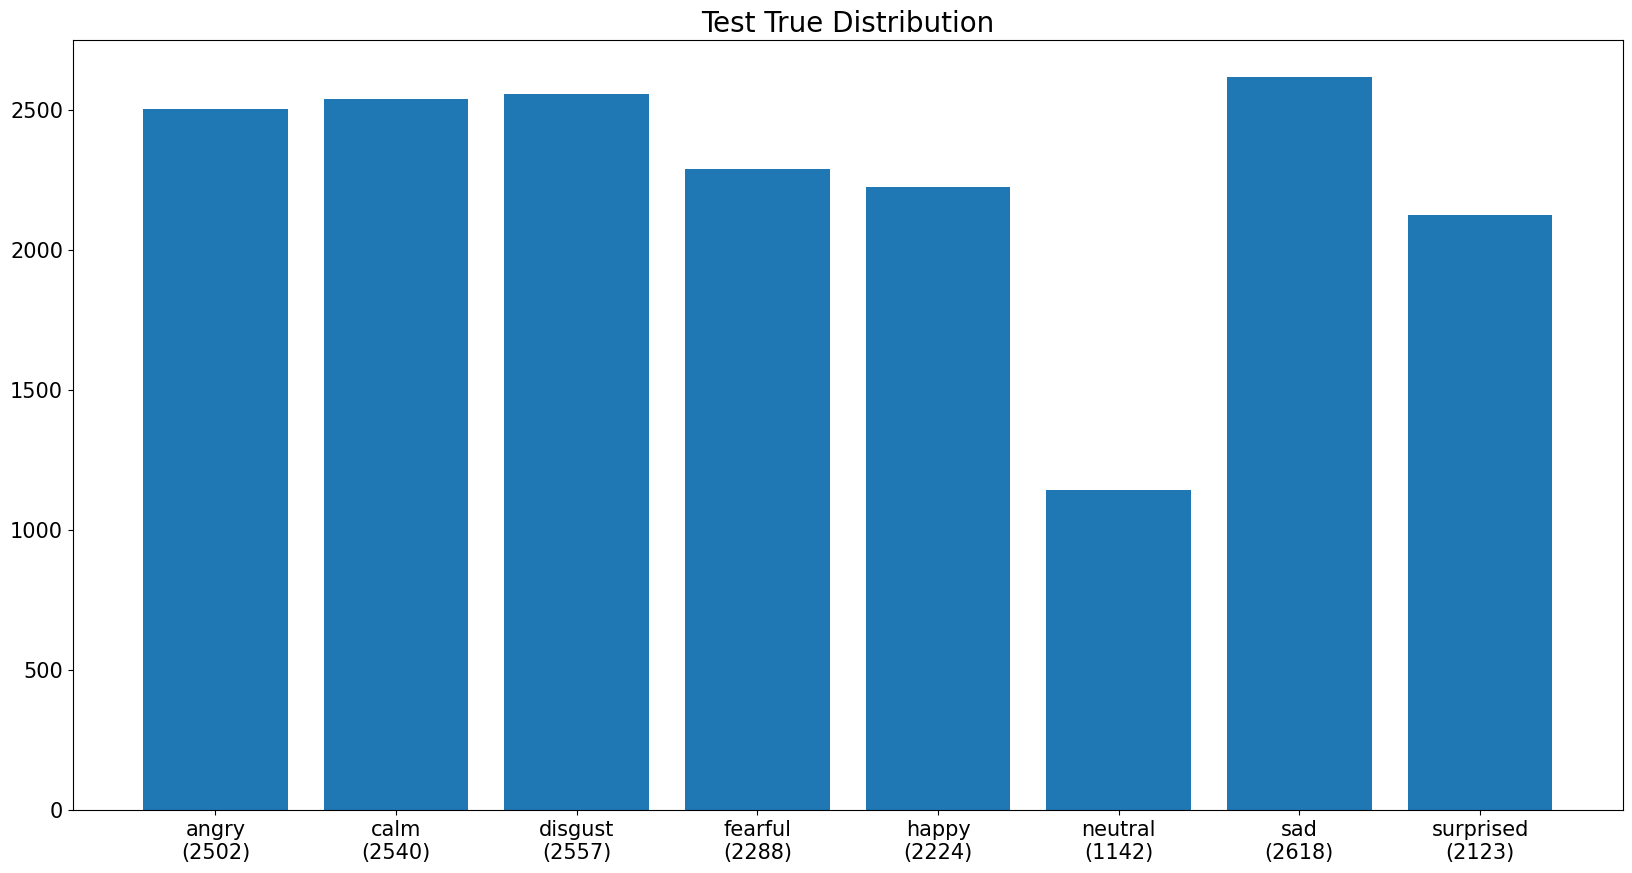

In [ ]:
# True Test Distribution
# unique, counts = np.unique(y_true, return_counts=True)
# collections.Counter(y_true)
counts = [np.count_nonzero(y_true == idx) for idx in range(len(label_names))]
valued_arr = []
# for i in range(len(label_names)):
for idx, name in enumerate(label_names):
    count = counts[idx]
    valued_arr.append(f'{name}\n({count})')

fig = plt.subplots(figsize=(20, 10))
plt.bar(valued_arr, counts)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Test True Distribution', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.savefig(Path(model_path, f'{model._name}_trueDist.png'))
plt.show()

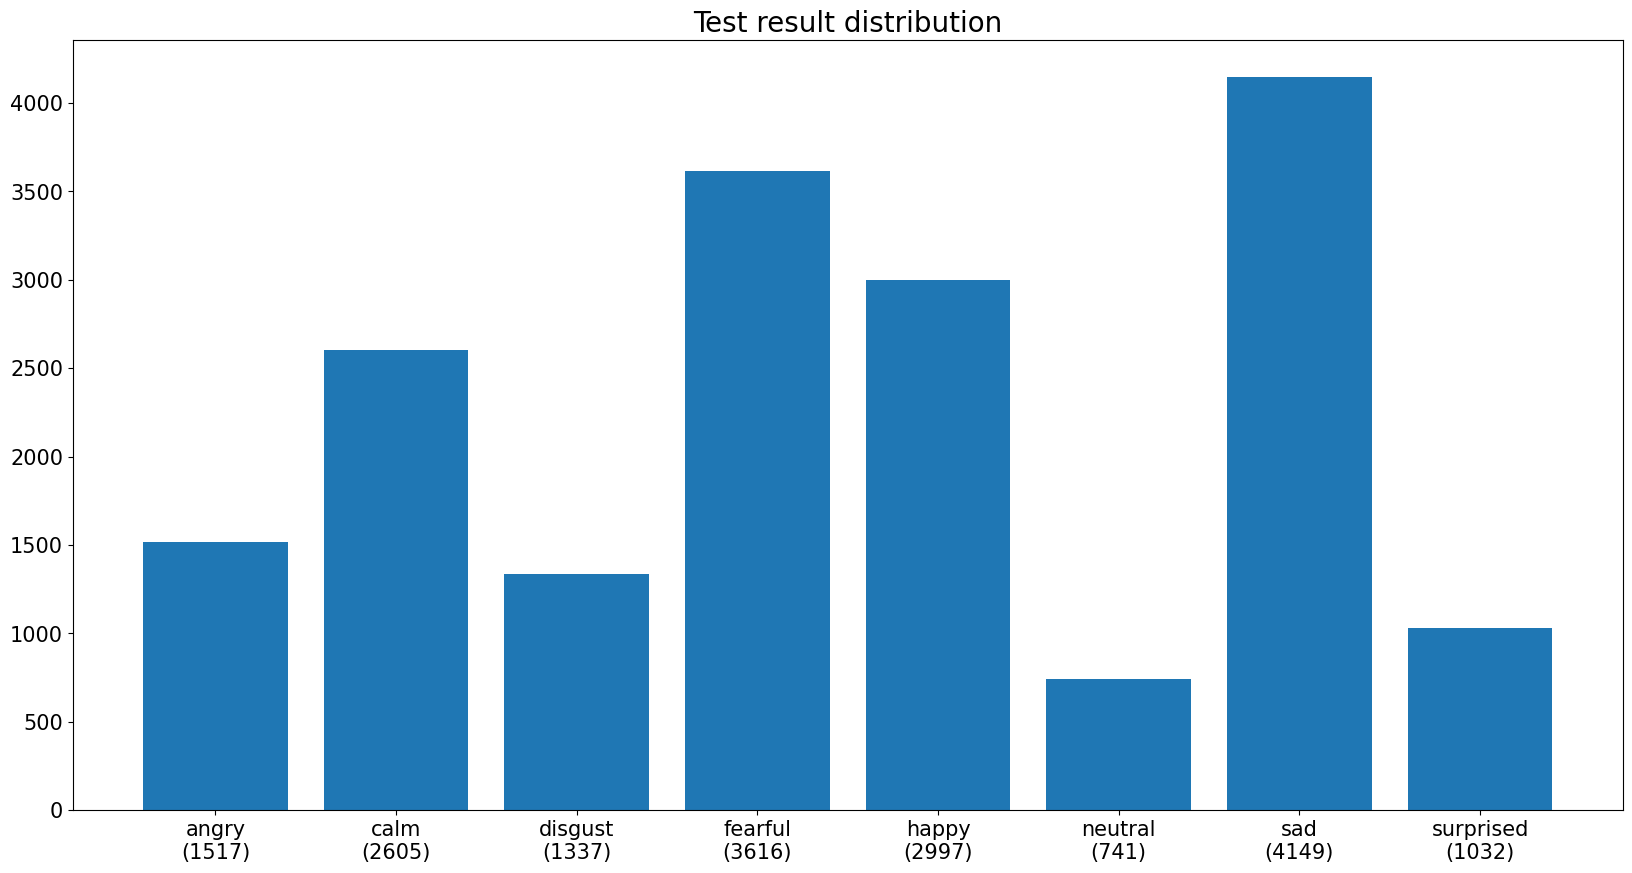

In [ ]:
# Predicted Test Distribution
# unique, counts = np.unique(y_pred, return_counts=True)
counts = [np.count_nonzero(y_pred == idx) for idx in range(len(label_names))]
valued_arr = []
unique_idx = 0
for idx, name in enumerate(label_names):
    count = counts[idx]
    valued_arr.append(f'{name}\n({count})')

fig = plt.subplots(figsize=(20, 10))
plt.bar(valued_arr, counts)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Test result distribution', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.savefig(Path(model_path, f'{model._name}_predDist.png'))
plt.show()

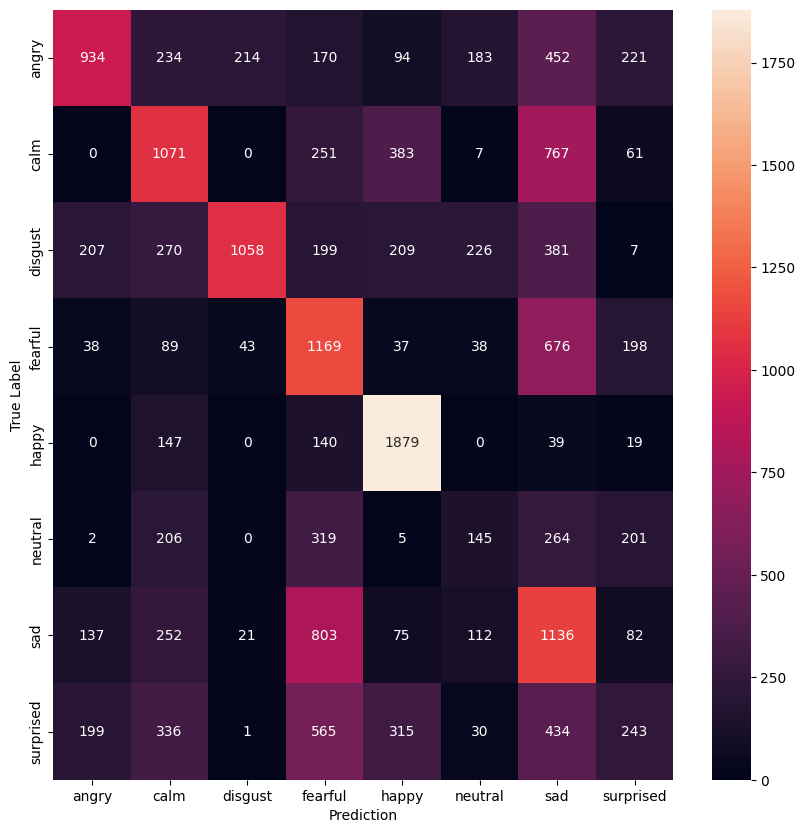

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='.4g')
plt.xlabel('Prediction')
plt.ylabel('True Label')
plt.savefig(Path(model_path, f'{model._name}_heat.png'))
plt.show()

In [ ]:
def multiclass_roc_auc_score(target, y_test, y_pred, average="macro"):
    # function for scoring roc auc score for multi-class
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    if len(target) > 2:
        for (idx, c_label) in enumerate(target):

            fpr, tpr, thresholds = roc_curve(
                y_test[:, idx].astype(int),
                y_pred[:, idx]
            )
            c_ax.plot(
                fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr))
            )
    else:
        fpr, tpr, thresholds = roc_curve(
                y_test,
                y_pred
        )
        c_ax.plot(
            fpr, tpr, label='Model (AUC:%0.2f)' % (auc(fpr, tpr)), color='#ff7f0e'
        )
    c_ax.plot(fpr, fpr, color='b', linestyle='--', label='Random Guessing')

    return roc_auc_score(y_test, y_pred, average=average)

ROC AUC score: 0.6610733943751134


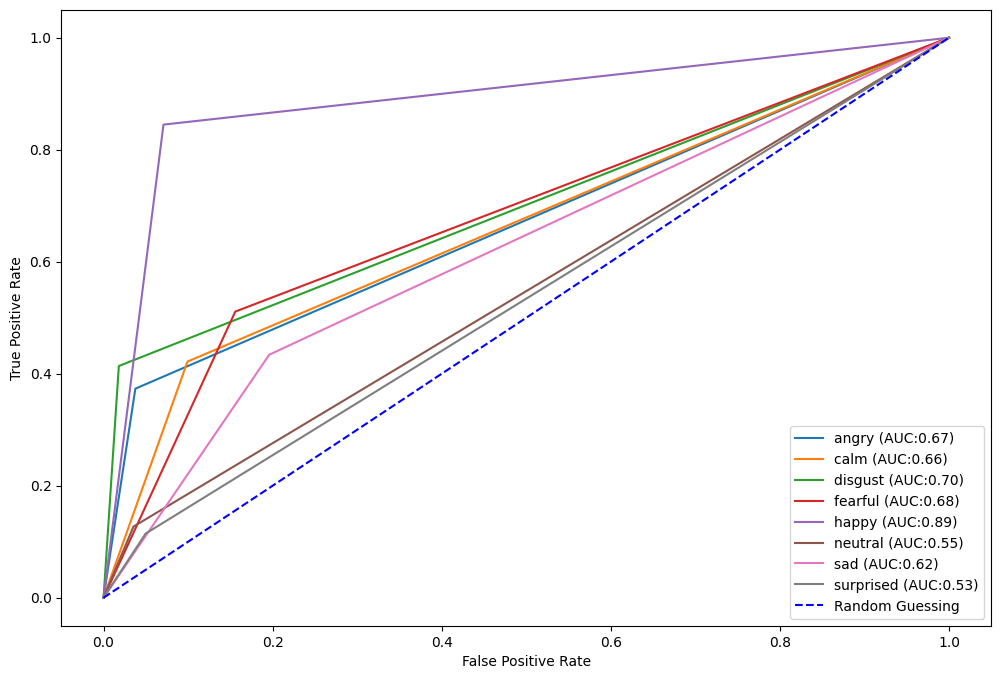

In [ ]:
# set plot figure size
fig, c_ax = plt.subplots(1, 1, figsize=(12, 8))

print('ROC AUC score:', multiclass_roc_auc_score(
    label_names,
    tf.reshape(y_true, (y_true.shape[0], 1)),
    tf.reshape(y_pred, (y_pred.shape[0], 1))
))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig(Path(model_path, f'{model._name}_ROC.png'))
plt.show()

## Run inference on an image file

Finally, verify the model's prediction output using an image

In [ ]:
labels

['angry', 'calm', 'disgust', 'fearful', 'happy', 'sad', 'surprised']

Generated/Frames/fearful/21/01-01-06-01-02-01-21-086-01.jpg


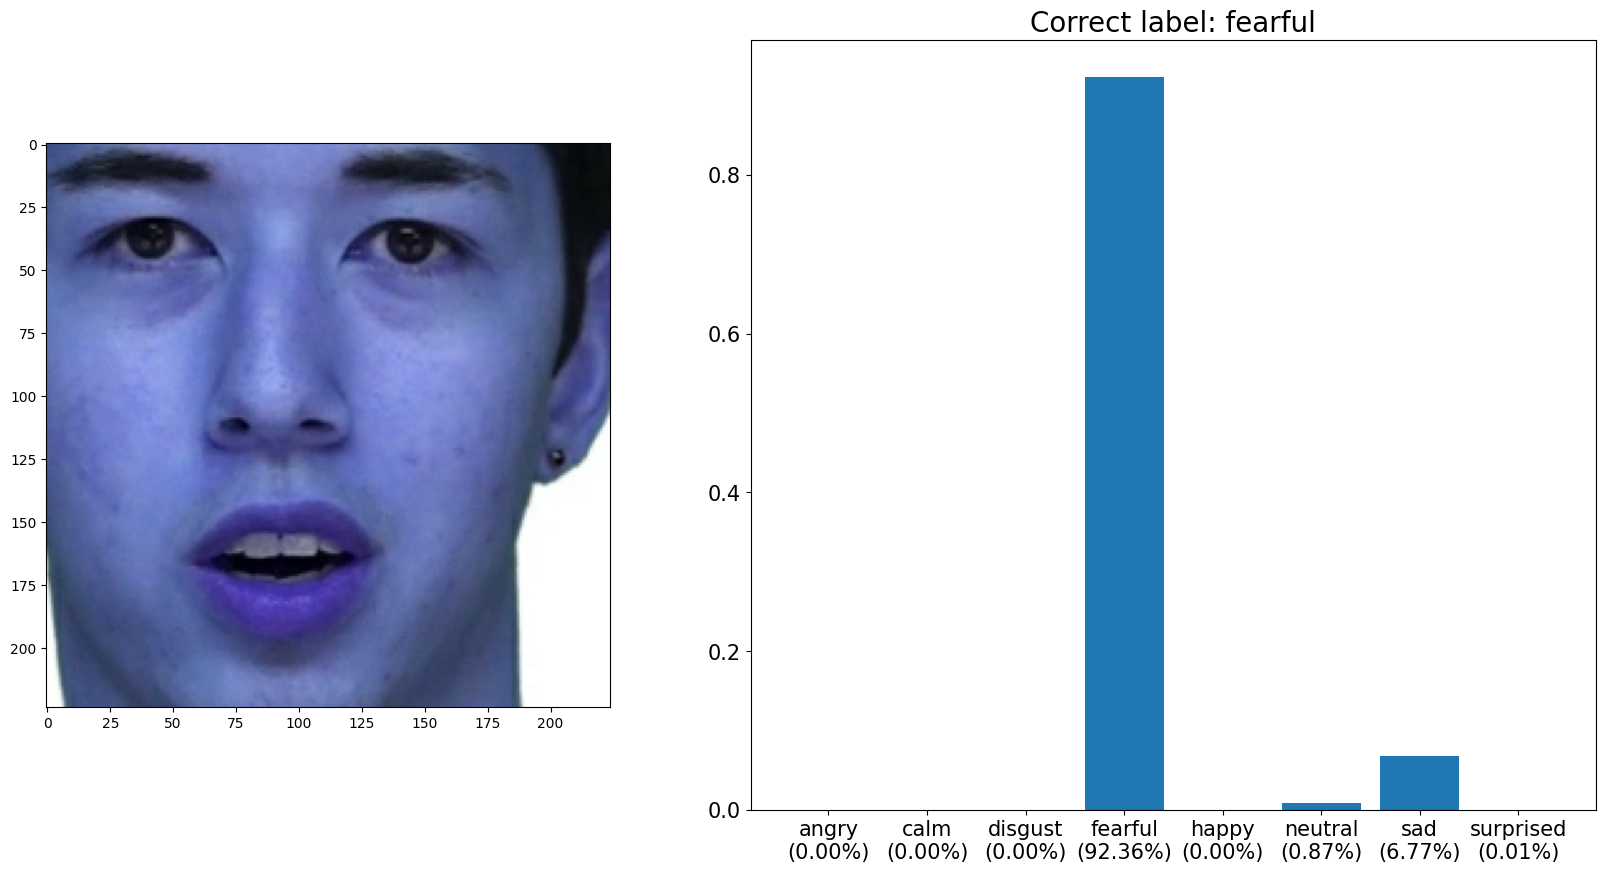

In [ ]:
# Take the first item of each class in test_files
# path = Path(next((subs for subs in test_files if 'angry' in subs), None))
# path = Path(next((subs for subs in test_files if 'calm' in subs), None))
# path = Path(next((subs for subs in test_files if 'disgust' in subs), None))
path = Path(next((subs for subs in test_files if 'fearful' in subs), None))
# path = Path(next((subs for subs in test_files if 'happy' in subs), None))
# path = Path(next((subs for subs in test_files if 'neutral' in subs), None))
# path = Path(next((subs for subs in test_files if 'sad' in subs), None))
# path = Path(next((subs for subs in test_files if 'surprised' in subs), None))
# path = Path('Generated/Frames/disgust/01-01-07-01-01-01-16-049-01.jpg')
print(path)
# print(tf.io.read_file(str(path)))
label = path.parent.parent.name



# image = cv2.imread(str(path))
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
# image = image / 255
# # image = preprocess_input(image)
image = prep_external_image(str(path), preprocess_vgg)
net_input = utils.extend_tensor(image, 0)
prediction = model(net_input)
prediction = prediction[0].numpy()

valued_arr = []

for idx, name in enumerate(labels):
    valued_arr.append(f'{name}\n({prediction[idx]:.2%})')

fig, ax = plt.subplots(
    nrows=1, ncols=2, width_ratios=[0.4, 0.6], figsize=(20, 10)
)

# pltDisplay(image * 255, ax=ax[0])  # 1 channel
pltDisplay(image / 255, ax=ax[0])  # 3 channels

ax[1].bar(valued_arr, prediction)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Correct label: {label}', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.show()

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [ ]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(
                shape=[None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS],
                dtype=tf.float32
            )
        )

    @tf.function
    def __call__(self, x):
        # If they pass a string, load the file and decode it.

        if x.dtype == tf.string:
            x = prep_external_image(x, preprocess_vgg)
            # x = tf.io.read_file(x)
            # x = tf.io.decode_jpeg(x, channels=IMG_CHANNELS, fancy_upscaling=False)
            # # x = cv2.imread(str(x))
            # # x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
            # # x = cv2.resize(x, (IMG_HEIGHT, IMG_WIDTH))
            # x = tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH))
            # # x = preprocess_input(x)
            # x = x / 255
            x = utils.extend_tensor(x, 0)

        result = self.model(x, training=False)

        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(labels, class_ids)
        return {'predictions': result,
                'class_ids': class_ids,
                'class_names': class_names}

Test run the "export" model:

In [ ]:
export = ExportModel(model)
img_path = 'calm/05/01-01-02-01-01-01-05-063-01.jpg'
img_path = Path(const.frames_path, img_path)
if img_path.is_file():
    export_res = export(tf.constant(
        str(img_path)
    ))
else:
    raise FileNotFoundError('File not found')

In [ ]:
# unpack dictionary
keys, values = zip(*export_res.items())

Generated/Frames/calm/05/01-01-02-01-01-01-05-063-01.jpg


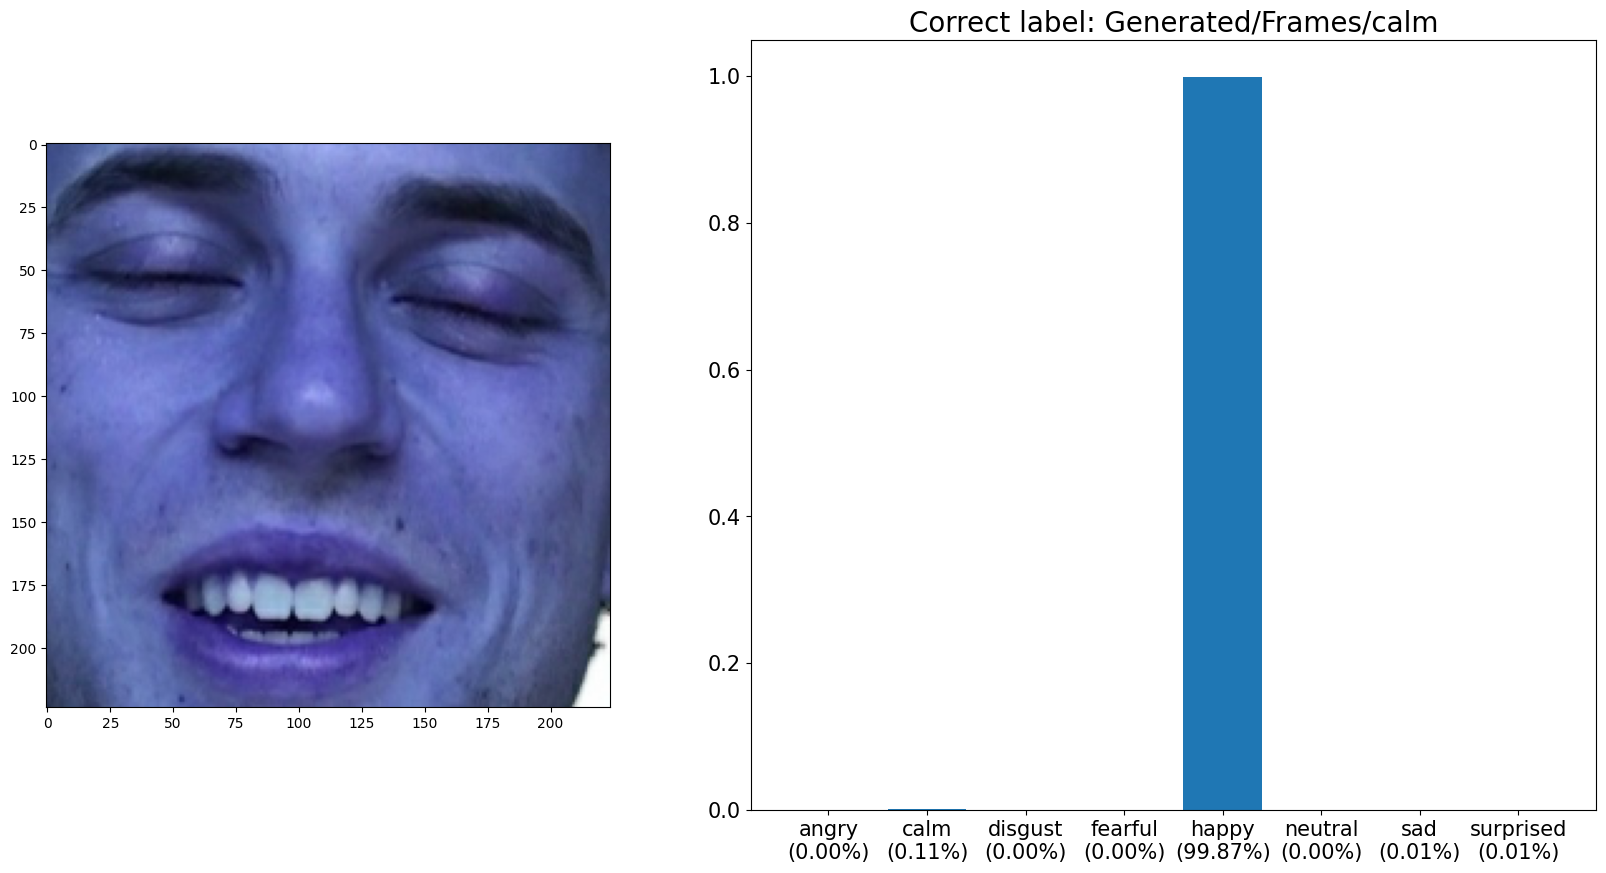

In [ ]:
prediction = export_res['predictions'][0].numpy()

valued_arr = []

for idx, name in enumerate(label_names):
    valued_arr.append(f'{name}\n({prediction[idx]:.2%})')

fig, ax = plt.subplots(
    nrows=1, ncols=2, width_ratios=[0.4, 0.6], figsize=(20, 10)
)
print(img_path)
# image = cv2.imread(str(Path(const.frames_path, img_path)))
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
image = prep_external_image(str(img_path), preprocess_vgg)
pltDisplay(image / 255, ax=ax[0])


ax[1].bar(valued_arr, prediction)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Correct label: {str(Path(img_path).parent.parent)}', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.show()

In [ ]:
E2E_model_path = Path(model_path, 'E2E/')
tf.saved_model.save(export, E2E_model_path)
imported = tf.saved_model.load(E2E_model_path)

imported_res = imported(tf.constant(str(img_path)
))

In [ ]:
np.array_equal(export_res['predictions'].numpy(), imported_res['predictions'].numpy())

True

In [ ]:
download_model_name = 'VGGFACE.7z'

In [ ]:
# command = f'jupyter nbconvert --to html FacialEmotionRecognition.ipynb --output {str(Path(model_path, "notebook.html"))}'
# subprocess.run(command, capture_output=True, shell=True)

In [ ]:
# command = f'jupyter nbconvert --to html FacialEmotionRecognition.ipynb --output {str(Path(model_path, "notebook.html"))}'
command = f'7z a -mx=0 {download_model_name} {model_path}'
subprocess.run(command, capture_output=True, shell=True)

CompletedProcess(args='7z a -mx=0 VGGFACE.7z Models/Frame/VGG16_VGGFACE/Run_1', returncode=0, stdout=b'\n7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21\np7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)\n\nScanning the drive:\n4 folders, 18 files, 410199299 bytes (392 MiB)\n\nCreating archive: VGGFACE.7z\n\nItems to compress: 22\n\n\nFiles read from disk: 18\nArchive size: 410199913 bytes (392 MiB)\nEverything is Ok\n', stderr=b'')

In [ ]:
command = f'cp {download_model_name} {PROJECT_FOLDER}'
subprocess.run(command, capture_output=True, shell=True)

CompletedProcess(args='cp VGGFACE.7z /content/drive/MyDrive/CNN_Emotion_Classification/', returncode=0, stdout=b'', stderr=b'')

--------------